In [2]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from Data_Load_Assign_Visual import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

| using device: cuda


In [4]:
# Load Dataset
train_data, test_data = load_MNIST()

# Get client dataloaders
iid_train_loader = iid_Assign(train_data)
noniid_train_loader = non_iid_Assign(train_data)
# print("iid_train_loader length", len(iid_train_loader))
# print("noniid_train_loader length", len(noniid_train_loader))

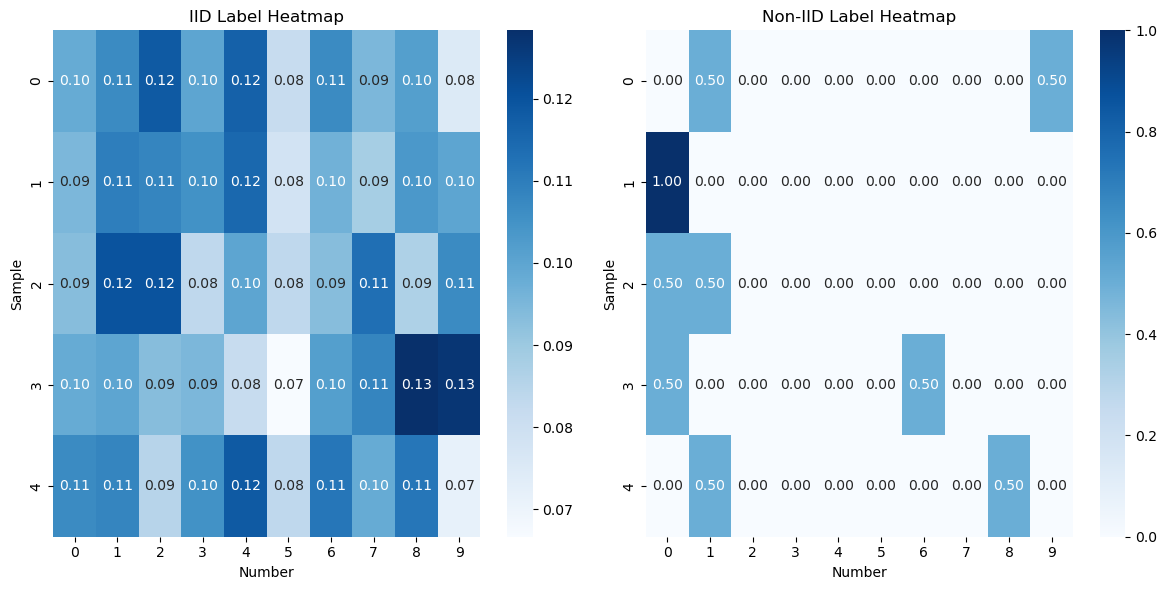

In [5]:
# Test iid and non-iid is correct.

# iid
sample_iid = random.sample(iid_train_loader, 5)
iid_labels = []
for i in sample_iid:
    iid_label = torch.zeros(10)
    for (x,y) in i:
        iid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    iid_labels.append(iid_label)
    
iid_labels = torch.stack(iid_labels)
iid_normalized = iid_labels / 600 # min-max normalization

# non_iid
sample_noniid = random.sample(noniid_train_loader, 5)
noniid_labels = []
for i in sample_noniid:
    noniid_label = torch.zeros(10)
    for (x,y) in i:
        noniid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    noniid_labels.append(noniid_label)
    
noniid_labels = torch.stack(noniid_labels)
noniid_normalized = noniid_labels / 600

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(iid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('IID Label Heatmap')

plt.subplot(1, 2, 2)
sns.heatmap(noniid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('Non-IID Label Heatmap')

plt.tight_layout()
plt.show()

In [6]:
# Model Defination

# Model 1: A simple multilayer-perceptron with 2-hidden
# layers with 200 units each using ReLu activations (199,210
# total parameters), which we refer to as the MNIST 2NN.

# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # torch.Size([B,784])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

print(MLP())
print("Total parameters of 2NN(MLP) is", num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total parameters of 2NN(MLP) is 199210


In [7]:
# Fed_Avg
def fedavg(global_model, C, K, E, c_loader, rounds, lr, acc_threshold):
    # C is the fraction of clients that perform computation on each round.
    assert C <= 1 and C >= 0
    # K is the number of clients.
    # E is the local epochs, the number of training passes each client makes
    # over its local dataset on each round.
    
    c_per_round = max( round(C * K), 1)
    accuracy = []
    entropys_of_rounds = []
    
    for rd in range(rounds):
        
        # Choose c_per_round clients
        clients = random.sample(range(K), c_per_round)
        
        # Train on clients one by one
        client_model = []
        entropys_of_clients = []
        for i, c in enumerate(clients):
            local_model, entropy = client_training(global_model, id = c, local_epochs = E, dataloader = c_loader[c], lr = lr)
            local_model = local_model.to(device)
            client_model.append(local_model.state_dict())
            entropys_of_clients.append(entropy)
        
        entropys_of_rounds.append(entropys_of_clients)
    
        # Average and iterate global model parameters for next round  
        keys = client_model[0].keys()
        next_global_dict = {key: 0 for key in keys}
        for key in keys:
            values = [d[key] for d in client_model]
            averaged_value = sum(values) / len(values)
            next_global_dict[key] = averaged_value
            
        global_model.load_state_dict(next_global_dict)
        global_model = global_model.to(device)
        
        # Validate accuracy this round
        test_inputs, test_labels = zip(*test_data)
        test_inputs = torch.stack(test_inputs).to(device)
        test_labels = torch.Tensor(test_labels).to(device)

        global_model.eval()
        with torch.no_grad():
            predictions = global_model(test_inputs)

        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

        acc = accuracy_score(true_labels, predicted_labels)
        if rd%10 == 0 or acc >= acc_threshold:
            print("The clients in round {} are: {}".format(rd, clients))
            print("Accuracy of round {}:{}".format(rd, acc))
            print()
        accuracy.append(acc)
        if acc >= acc_threshold:
            break
        
    return accuracy, entropys_of_rounds

Choose entropy for uncertainty estimation:
$$\mathbb{H}[y|\mathbf{x},\mathcal{D}_{train}]:=-\sum_{c}p(y=c|\mathbf{x},\mathcal{D}_{train})\log p(y=c|\mathbf{x},\mathcal{D}_{train})$$

In [31]:
# Calculate the averaged entropy of the local model after every local training
def calculate_entropy(logits):
    # The differences between 2NN and CNN, 2NN doesn't have a softmax layer
    probabilities = F.softmax(logits, dim=1)
    log_probabilities = torch.log2(probabilities)
    entropy = -torch.sum(probabilities * log_probabilities, dim=1)
    return entropy.mean().item()

In [32]:
criterion = nn.CrossEntropyLoss()

def client_training(global_model, id, local_epochs, dataloader, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    
    for epoch in range(local_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Calculate the Averaged Entropy After All Epoches:
        if epoch == local_epochs - 1:
            with torch.no_grad():
                outputs = local_model(inputs)
                entropy = calculate_entropy(outputs)            
            
    return local_model, entropy

# MNIST 2NN

In [33]:
mlp = MLP()
acc_threshold_2nn = 0.97

In [51]:
def pltUncertainty(A, title):
    max_values = [np.max(a_i) for a_i in A]
    min_values = [np.min(a_i) for a_i in A]
    avg_values = [np.mean(a_i) for a_i in A]


    fig, ax = plt.subplots()

    ax.fill_between(np.log10(range(1, len(A) + 1)), min_values, max_values, facecolor='red', alpha=0.2)

    ax.plot(np.log10(range(1, len(A) + 1)), avg_values, color='blue')

    # plt.ylim(-0.1, 1)
    plt.xticks(np.log10(range(1, len(A) + 1, len(A) // 5)), range(1, len(A) + 1, len(A) // 5))
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Uncertainty(Entropy)')
    ax.set_title(title)

    plt.show()

## 1. iid,  C = 0.1

In [34]:
# iid C = 0.1
mlp_iid1 = copy.deepcopy(mlp)
acc_mlp_iid1, entropy_2nn_iid1 = fedavg(mlp_iid1, C = 0.1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [31, 27, 36, 94, 84, 0, 68, 65, 54, 6]
Accuracy of round 0:0.5007

The clients in round 10 are: [51, 90, 24, 40, 37, 49, 7, 26, 4, 92]
Accuracy of round 10:0.9028

The clients in round 20 are: [79, 80, 58, 90, 19, 78, 77, 5, 32, 43]
Accuracy of round 20:0.9267

The clients in round 30 are: [55, 21, 0, 18, 72, 5, 56, 16, 43, 1]
Accuracy of round 30:0.9409

The clients in round 40 are: [57, 65, 90, 12, 24, 21, 56, 8, 54, 81]
Accuracy of round 40:0.9499

The clients in round 50 are: [74, 10, 71, 22, 33, 25, 41, 89, 90, 32]
Accuracy of round 50:0.9566

The clients in round 60 are: [8, 45, 12, 15, 3, 44, 2, 22, 51, 78]
Accuracy of round 60:0.9604

The clients in round 70 are: [53, 55, 72, 87, 42, 91, 31, 17, 46, 65]
Accuracy of round 70:0.9643

The clients in round 80 are: [34, 48, 93, 26, 44, 17, 16, 14, 78, 45]
Accuracy of round 80:0.9667

The clients in round 87 are: [19, 18, 0, 74, 76, 81, 90, 66, 13, 89]
Accuracy of round 87:0.9701



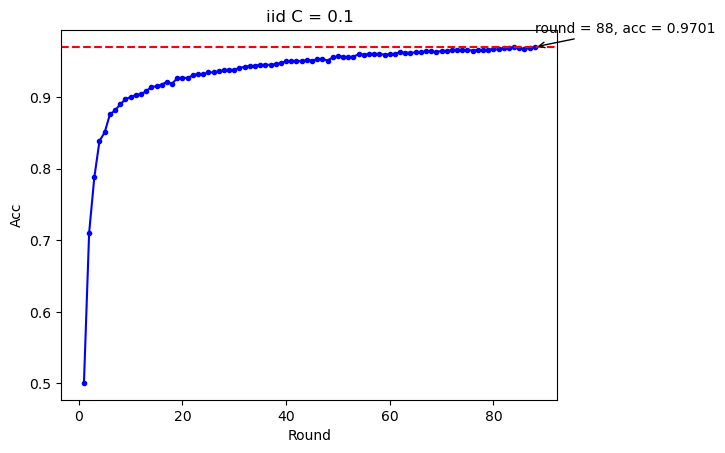

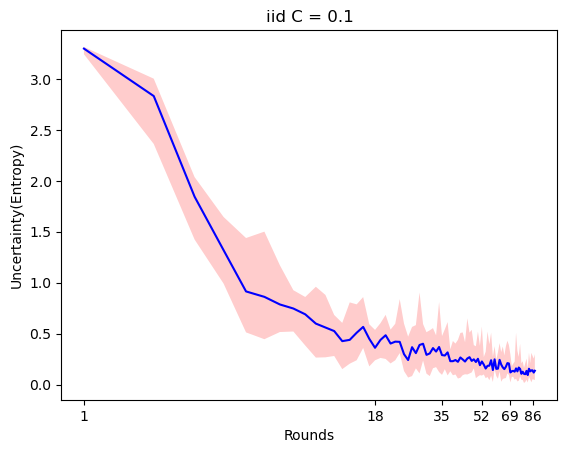

88 rounds needed to achieve the accuracy of 0.9701


In [52]:
pltAcc(acc_mlp_iid1, acc_threshold_2nn, 'iid C = 0.1')
pltUncertainty(entropy_2nn_iid1, 'iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid1), acc_mlp_iid1[-1]))

## 2. iid, C = 0.2

In [47]:
# iid C = 0.2
mlp_iid2 = copy.deepcopy(mlp)
acc_mlp_iid2, entropy_2nn_iid2  = fedavg(mlp_iid2, C = 0.2, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [99, 82, 89, 26, 76, 77, 65, 14, 34, 88, 93, 78, 21, 48, 10, 4, 1, 46, 92, 61]
Accuracy of round 0:0.5809

The clients in round 10 are: [29, 55, 6, 73, 98, 5, 52, 11, 33, 25, 92, 41, 22, 14, 23, 89, 46, 3, 1, 48]
Accuracy of round 10:0.9057

The clients in round 20 are: [50, 56, 84, 40, 59, 8, 18, 28, 96, 14, 19, 90, 69, 26, 47, 5, 2, 51, 11, 52]
Accuracy of round 20:0.9292

The clients in round 30 are: [36, 4, 2, 1, 81, 34, 9, 84, 40, 70, 83, 6, 90, 31, 88, 66, 17, 33, 76, 7]
Accuracy of round 30:0.9419

The clients in round 40 are: [83, 67, 6, 93, 24, 32, 58, 88, 8, 2, 25, 76, 13, 0, 27, 23, 79, 22, 84, 46]
Accuracy of round 40:0.9513

The clients in round 50 are: [94, 41, 18, 42, 74, 96, 8, 11, 47, 26, 32, 57, 87, 62, 60, 68, 67, 10, 40, 56]
Accuracy of round 50:0.9575

The clients in round 60 are: [14, 7, 42, 20, 97, 34, 78, 92, 71, 56, 39, 70, 53, 61, 47, 28, 86, 11, 10, 80]
Accuracy of round 60:0.9617

The clients in round 70 are: [79, 55, 76, 50, 82, 

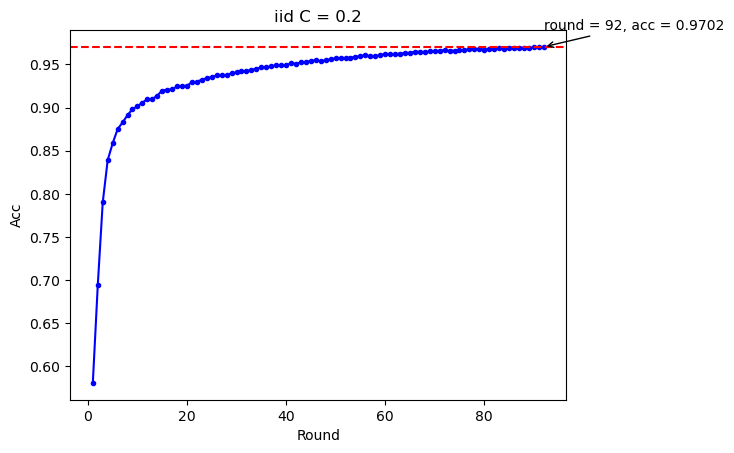

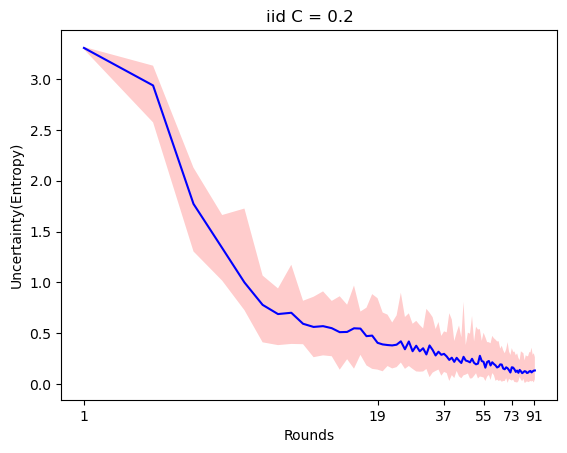

92 rounds needed to achieve the accuracy of 0.9702


In [53]:
pltAcc(acc_mlp_iid2, acc_threshold_2nn, 'iid C = 0.2')
pltUncertainty(entropy_2nn_iid2, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid2), acc_mlp_iid2[-1]))

## 3. iid, C = 0.5

In [49]:
# iid C = 0.5
mlp_iid3 = copy.deepcopy(mlp)
acc_mlp_iid3, entropy_2nn_iid3 = fedavg(mlp_iid3, C = 0.5, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [47, 1, 25, 72, 26, 8, 62, 16, 84, 11, 66, 88, 85, 70, 51, 78, 35, 95, 10, 54, 2, 69, 61, 43, 0, 97, 37, 53, 57, 65, 36, 94, 4, 90, 44, 48, 52, 24, 50, 41, 86, 64, 40, 49, 14, 18, 31, 74, 83, 75]
Accuracy of round 0:0.5806

The clients in round 10 are: [41, 46, 37, 57, 43, 31, 20, 59, 16, 90, 95, 28, 63, 19, 12, 68, 75, 77, 56, 40, 22, 11, 80, 93, 34, 45, 14, 73, 48, 99, 70, 39, 42, 0, 24, 38, 23, 10, 54, 35, 62, 30, 15, 5, 74, 33, 91, 55, 6, 3]
Accuracy of round 10:0.9057

The clients in round 20 are: [1, 82, 76, 51, 99, 55, 29, 94, 72, 59, 37, 0, 22, 73, 58, 68, 8, 98, 95, 5, 11, 16, 50, 49, 87, 28, 70, 13, 3, 80, 77, 96, 36, 21, 48, 71, 40, 63, 26, 33, 12, 32, 84, 75, 38, 15, 43, 2, 61, 31]
Accuracy of round 20:0.9305

The clients in round 30 are: [5, 69, 64, 38, 40, 34, 79, 80, 95, 9, 44, 2, 57, 93, 22, 45, 78, 37, 33, 62, 0, 87, 20, 31, 89, 29, 14, 6, 48, 56, 71, 4, 41, 3, 1, 58, 32, 13, 75, 11, 74, 72, 61, 49, 47, 25, 35, 66, 16, 97]
Accuracy of round 

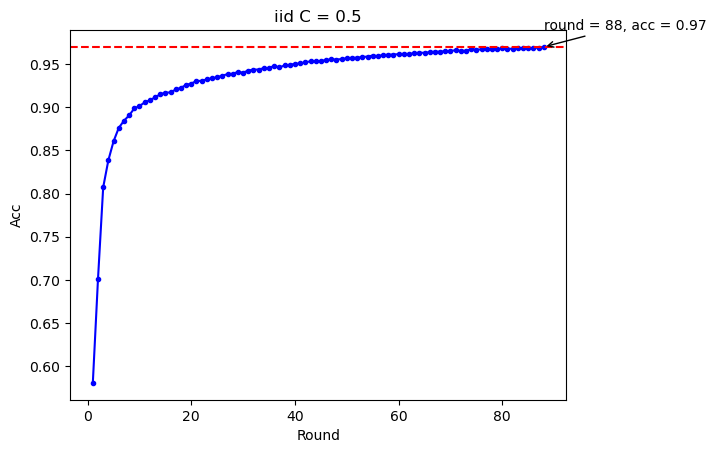

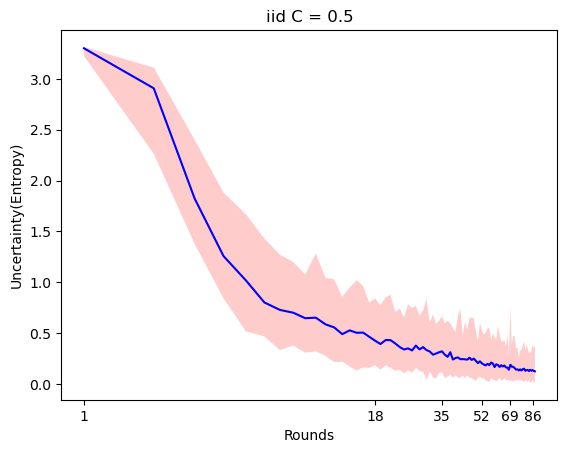

88 rounds needed to achieve the accuracy of 0.97


In [54]:
pltAcc(acc_mlp_iid3, acc_threshold_2nn, 'iid C = 0.5')
pltUncertainty(entropy_2nn_iid3, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid3), acc_mlp_iid3[-1]))

## 4. iid, C = 1

In [ ]:
# iid C = 1
mlp_iid4 = copy.deepcopy(mlp)
acc_mlp_iid4, entropy_2nn_iid4 = fedavg(mlp_iid4, C = 1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [80, 16, 36, 17, 35, 6, 1, 30, 46, 42, 84, 99, 14, 57, 81, 7, 95, 19, 62, 27, 29, 90, 11, 13, 33, 85, 59, 39, 53, 91, 69, 23, 77, 15, 98, 51, 34, 5, 54, 63, 37, 45, 61, 18, 86, 75, 10, 58, 92, 26, 66, 68, 96, 47, 21, 67, 65, 76, 94, 56, 24, 25, 52, 79, 41, 4, 49, 71, 97, 83, 40, 44, 72, 8, 93, 60, 0, 22, 28, 87, 9, 31, 82, 32, 74, 43, 48, 70, 88, 2, 78, 89, 50, 64, 12, 3, 73, 55, 20, 38]
Accuracy of round 0:0.586

The clients in round 10 are: [39, 18, 49, 85, 89, 53, 84, 62, 60, 41, 72, 21, 31, 44, 40, 79, 88, 73, 52, 48, 42, 90, 69, 81, 98, 56, 10, 38, 97, 25, 3, 66, 74, 28, 99, 1, 64, 51, 58, 75, 65, 76, 0, 54, 77, 95, 15, 32, 83, 23, 22, 5, 61, 37, 17, 63, 8, 55, 4, 35, 92, 78, 46, 45, 9, 71, 94, 57, 27, 36, 82, 13, 50, 12, 59, 26, 14, 70, 93, 16, 47, 87, 43, 34, 11, 86, 7, 80, 30, 6, 29, 91, 19, 33, 20, 24, 2, 68, 67, 96]
Accuracy of round 10:0.9054

The clients in round 20 are: [67, 28, 72, 3, 49, 4, 17, 13, 93, 88, 9, 57, 47, 27, 79, 21, 34, 10, 53, 41

In [ ]:
pltAcc(acc_mlp_iid4, acc_threshold_2nn, 'iid C = 1')
pltUncertainty(entropy_2nn_iid4, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid4), acc_mlp_iid4[-1]))

## 5. non-iid, C = 0.1

In [ ]:
# non-iid C = 0.1
mlp_noniid1 = copy.deepcopy(mlp)
acc_mlp_noniid1, entropy_2nn_noniid1 = fedavg(mlp_noniid1, C = 0.1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid1, acc_threshold_2nn, 'non-iid C = 0.1')
pltUncertainty(entropy_2nn_noniid1, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid1), acc_mlp_noniid1[-1]))

## 6. non-iid, C = 0.2

In [ ]:
# non-iid C = 0.2
mlp_noniid2 = copy.deepcopy(mlp)
acc_mlp_noniid2, entropy_2nn_noniid2 = fedavg(mlp_noniid2, C = 0.2, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid2, acc_threshold_2nn, 'non-iid C = 0.2')
pltUncertainty(entropy_2nn_noniid2, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid2), acc_mlp_noniid2[-1]))

## 7. non-iid, C = 0.5

In [ ]:
# non-iid C = 0.5
mlp_noniid3 = copy.deepcopy(mlp)
acc_mlp_noniid3, entropy_2nn_noniid3 = fedavg(mlp_noniid3, C = 0.5, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid3, acc_threshold_2nn, 'non-iid C = 0.5')
pltUncertainty(entropy_2nn_noniid3, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid3), acc_mlp_noniid3[-1]))

## 8. non-iid, C = 1

In [ ]:
# non-iid C = 1
mlp_noniid4 = copy.deepcopy(mlp)
acc_mlp_noniid4, entropy_2nn_noniid4 = fedavg(mlp_noniid4, C = 1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid4, acc_threshold_2nn, 'non-iid C = 1')
pltUncertainty(entropy_2nn_noniid4, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid4), acc_mlp_noniid4[-1]))

## Comparison among 8 groups

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_mlp_iid1) + 1)), acc_mlp_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_iid2) + 1)), acc_mlp_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_iid3) + 1)), acc_mlp_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_iid4) + 1)), acc_mlp_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid1) + 1)), acc_mlp_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid2) + 1)), acc_mlp_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_noniid3) + 1)), acc_mlp_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_noniid4) + 1)), acc_mlp_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_2nn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST 2NN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()